# VAE (Variational Auto Encoders)

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,random_split
import tqdm
import matplotlib.pyplot as plt

    Control Devices:

In [2]:
devices=("cuda" if torch.cuda.is_available() else "cpu")

    Constants:

In [3]:
Epochs=20
Learning_rate=2e-4
Num_Embeddings=128
Channel_size=3
Save_path="VAE_model.pth.tar"

    Create Transforms, Dataset and Dataloader:

In [4]:
# Transformer
transformer=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Datasets
train_dataset=datasets.MNIST("Mnist",train=True,transform=transformer,download=True)
valid_dataset,train_dataset=random_split(train_dataset,lengths=[10000,len(train_dataset)-10000])

# Dataloaders
valid_dataloader=DataLoader(dataset=valid_dataset,batch_size=20,drop_last=True,shuffle=True)
train_dataloader=DataLoader(dataset=train_dataset,batch_size=20,drop_last=True,shuffle=True)


100%|██████████| 9912422/9912422 [00:01<00:00, 7843479.33it/s]


Extracting Mnist\MNIST\raw\train-images-idx3-ubyte.gz to Mnist\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 2274080.01it/s]

Extracting Mnist\MNIST\raw\train-labels-idx1-ubyte.gz to Mnist\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5172186.87it/s]


Extracting Mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to Mnist\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting Mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to Mnist\MNIST\raw



    Create VAE Module:

In [5]:
class VAE(nn.Module):
    def __init__(self,input_dim,hidden_dim,z_dim):
        super().__init__()
        
        self.encoder=self.encoder_fn(input_dim=input_dim,hidden_dim=hidden_dim)
        self.means,self.std=self.latent_space(hidden_dim=hidden_dim,z_dim=z_dim)
        self.decoder=self.decoder_fn(hidden_dim=hidden_dim,input_dim=input_dim,z_dim=z_dim)

    # Encoder
    def encoder_fn(self,input_dim,hidden_dim):
        
        encoder=nn.Sequential(nn.Linear(input_dim,512),
                              nn.ReLU(),
                              nn.Linear(512,256),
                              nn.ReLU(),
                              nn.Linear(256,hidden_dim),
                              nn.ReLU())
        return encoder
 
    
    # Calculate Means, Variances
    def latent_space(self,hidden_dim,z_dim):
        
        means=nn.Linear(hidden_dim,z_dim)
        std=nn.Linear(hidden_dim,z_dim)
        return means, std
  
    
    # Decoder
    def decoder_fn(self,hidden_dim,z_dim,input_dim):
        
        decoder=nn.Sequential(nn.Linear(z_dim,hidden_dim),
                              nn.ReLU(),
                              nn.Linear(hidden_dim,256),
                              nn.ReLU(),
                              nn.Linear(256,512),
                              nn.ReLU(),
                              nn.Linear(512,input_dim),
                              nn.Sigmoid())
        
        return decoder
    
    
    def forward(self,data):
        x=self.encoder(data)
        
        mean=self.means(x) # Means dim
        std=self.std(x)    # Variance
        
        epsilon=torch.randn_like(std) # Epsilon
        
        latent_spc=mean+(std*epsilon) # Latent space out for decoder input
        
        out=self.decoder(latent_spc) # Decoder
         
        return out,mean,std
        
    

    Create model, optimizer ,loss_fn:

In [6]:
# Model
model=VAE(input_dim=28*28,hidden_dim=128,z_dim=16)
model.to(devices)

# Optimizer
optimizer=torch.optim.Adam(params=model.parameters(),lr=3e-4,betas=(0.5,0.999))

# Loss
loss_fn=nn.BCELoss(reduction="sum")

    Model save:
    

In [7]:
def Save_model(model,optimizer,epoch,path):
    checkpoints={"Epochs":epoch,
                 "Optimizer_state":optimizer.state_dict,
                 "Model_states": model.state_dict}
    print("Model is saving...")
    torch.save(checkpoints,f=path)

    Training:

In [8]:
def Training(epochs,train_dataloader,optimizer,model,loss_fn,Save_path,save_model_fn):
    for epoch in range(epochs):
        
        prograss_bar=tqdm.tqdm(range(len(train_dataloader)),"Train proccess")
        
        for batch,(img,_label_) in enumerate(train_dataloader):
            
            img=img.reshape(img.shape[0],-1).to(devices)
            
            optimizer.zero_grad()
            out,mean,std=model(img)
            
            # Loss
            loss1=loss_fn(out,img)
            
            # KL-divergences
            kl_div=-torch.sum(1+torch.log(torch.pow(std,2))-torch.pow(mean,2)-torch.pow(std,2))
            
            # Total loss
            loss=loss1+kl_div
            loss.backward()
            optimizer.step()
            
            prograss_bar.update(1)   
        
        prograss_bar.set_postfix({"EPOCH":epoch+1,"step":batch+1,"LOSS": (loss.item()/(batch+1))})
        prograss_bar.close()
        
        save_model_fn(model,optimizer,epoch+1,Save_path)
        

In [10]:
Training(epochs=Epochs,train_dataloader=train_dataloader,optimizer=optimizer,model=model,loss_fn=loss_fn,Save_path=Save_path,save_model_fn=Save_model)

Train proccess: 100%|██████████| 2500/2500 [00:30<00:00, 80.91it/s, EPOCH=1, step=2500, LOSS=-425]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:30<00:00, 82.89it/s, EPOCH=2, step=2500, LOSS=-446]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:32<00:00, 77.80it/s, EPOCH=3, step=2500, LOSS=-459]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:30<00:00, 83.05it/s, EPOCH=4, step=2500, LOSS=-479]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:31<00:00, 79.45it/s, EPOCH=5, step=2500, LOSS=-473]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:27<00:00, 89.91it/s, EPOCH=6, step=2500, LOSS=-480]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:27<00:00, 91.93it/s, EPOCH=7, step=2500, LOSS=-473]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:26<00:00, 92.91it/s, EPOCH=8, step=2500, LOSS=-471]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:27<00:00, 89.80it/s, EPOCH=9, step=2500, LOSS=-476]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:30<00:00, 81.30it/s, EPOCH=10, step=2500, LOSS=-482]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:29<00:00, 84.93it/s, EPOCH=11, step=2500, LOSS=-464]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:33<00:00, 74.81it/s, EPOCH=12, step=2500, LOSS=-478]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:28<00:00, 88.32it/s, EPOCH=13, step=2500, LOSS=-475]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:26<00:00, 94.25it/s, EPOCH=14, step=2500, LOSS=-460]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:30<00:00, 82.00it/s, EPOCH=15, step=2500, LOSS=-497]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:29<00:00, 85.85it/s, EPOCH=16, step=2500, LOSS=-475]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:32<00:00, 75.94it/s, EPOCH=17, step=2500, LOSS=-471]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:32<00:00, 76.54it/s, EPOCH=18, step=2500, LOSS=-483]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:32<00:00, 77.36it/s, EPOCH=19, step=2500, LOSS=-482]


Model is saving...


Train proccess: 100%|██████████| 2500/2500 [00:30<00:00, 82.47it/s, EPOCH=20, step=2500, LOSS=-499]


Model is saving...


    Visualize Images:

In [11]:
def Visualize_Test(Test_dataloader,model):
    with torch.no_grad():
        for batch,(img_test,_) in enumerate(Test_dataloader):
            img_test=img_test.to(devices)
            
            out,_mean_,_std_=model(img_test.reshape(img_test.shape[0],-1))
            
            out_img=out.reshape(-1,28,28)
            
            if batch==3:
                break
    for i in range(20):
        plt.subplot(4,5,i+1)
        plt.imshow(out_img[i].cpu().detach())
    
    plt.show()


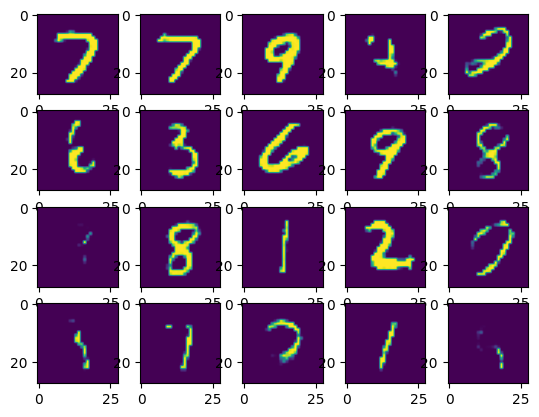

In [12]:
Visualize_Test(Test_dataloader=train_dataloader,model=model)